### Imports

In [17]:
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism
import torch
import numpy as np
import pywt

### Directory for data

In [3]:
root_dir = "../trial-data"

In [4]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            
            result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            result.append(torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1))
            result.append(d[key] == 2)
            d[key] = torch.stack(result, axis=0).float()
        return d

### Transforms to Apply 

In [7]:
train_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[192, 192, 60], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

### Load Dataset

In [8]:
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)

val_ds = val_ds[50:]
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)

### Example Images and Segments

image shape: torch.Size([4, 240, 240, 155])


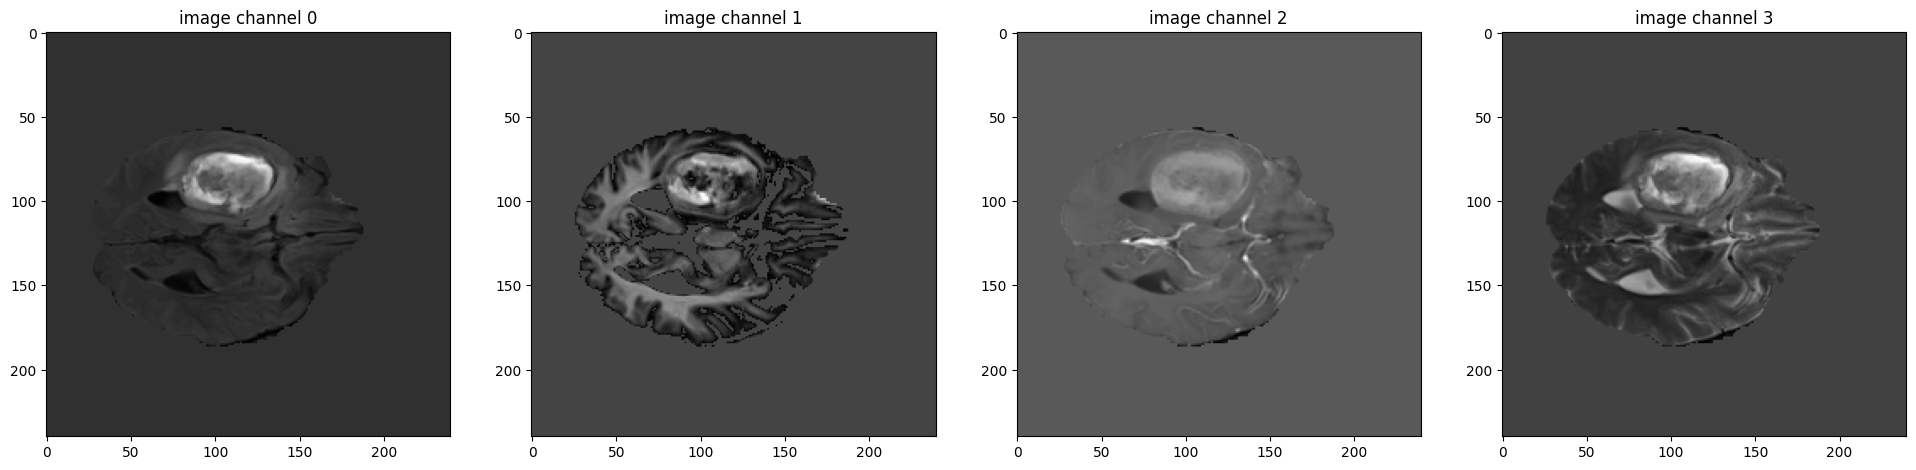

label shape: torch.Size([3, 240, 240, 155])


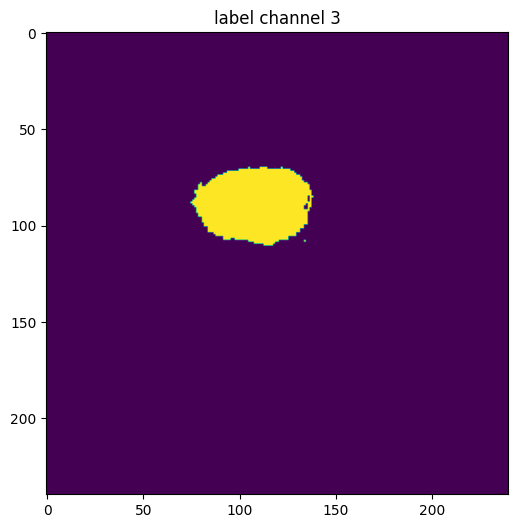

In [11]:
val_data_example = val_ds[2]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, 60].detach().cpu(), cmap="gray")
plt.show()


print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))

plt.subplot(1, 1, 1)
plt.title(f"label channel {i}")
plt.imshow(val_data_example["label"][1, :, :, 60].detach().cpu())
plt.show()

### Loading Model, Metrics and Inference

In [30]:
max_epochs = 300
val_interval = 1
VAL_AMP = True

device = torch.device("cpu")
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=4,
    out_channels=3,
    dropout_prob=0.2,
).to(device)
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)

scaler = torch.cuda.amp.GradScaler()
torch.backends.cudnn.benchmark = True

### Load Model Weights

In [31]:
#model.load_state_dict(torch.load('model-Segmentation-Pretrained.pt', map_location = torch.device('cpu')))
model.load_state_dict(torch.load('best_metric_model-segResNet.pth', map_location = torch.device('cpu')))

<All keys matched successfully>

### Inference without Denoising

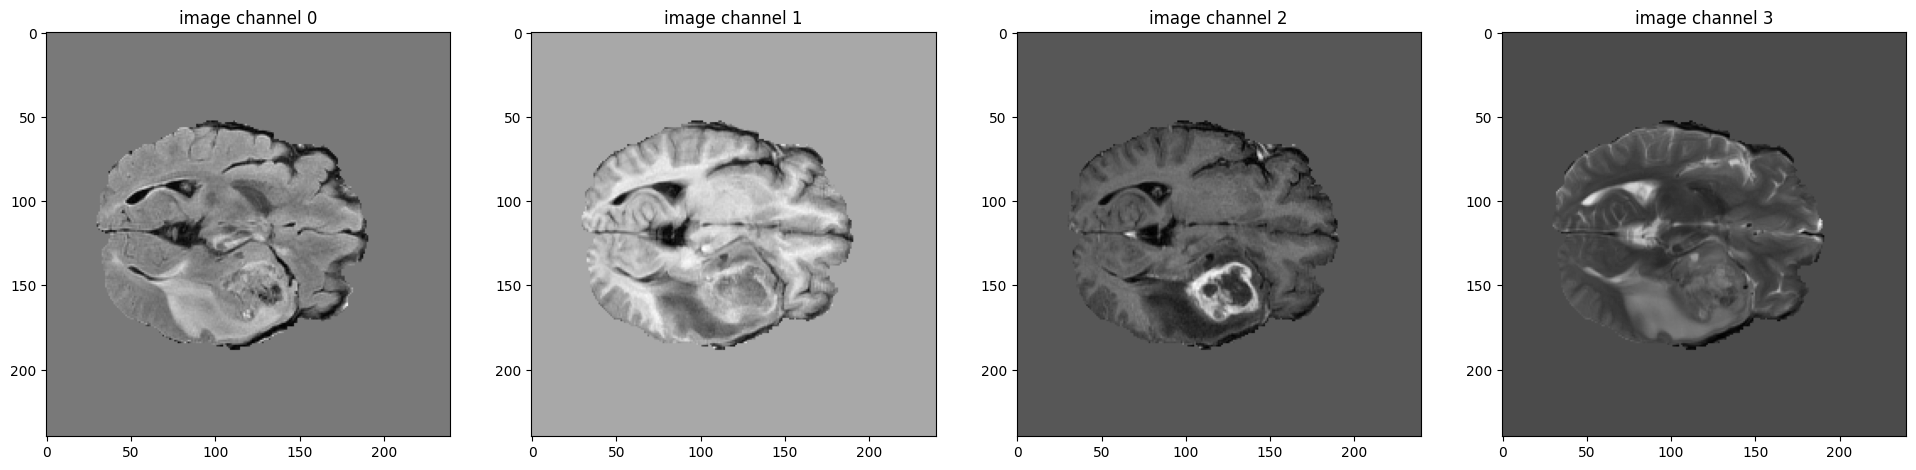

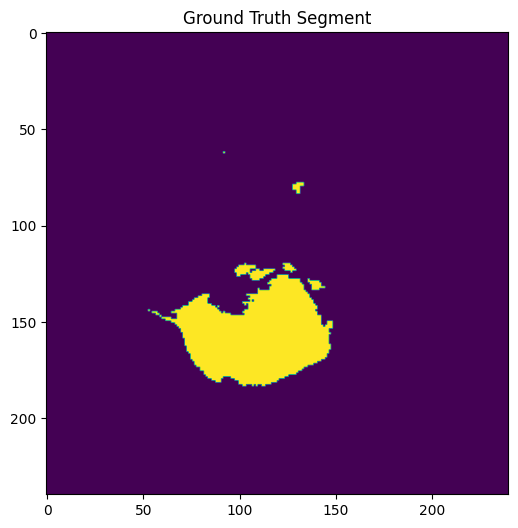

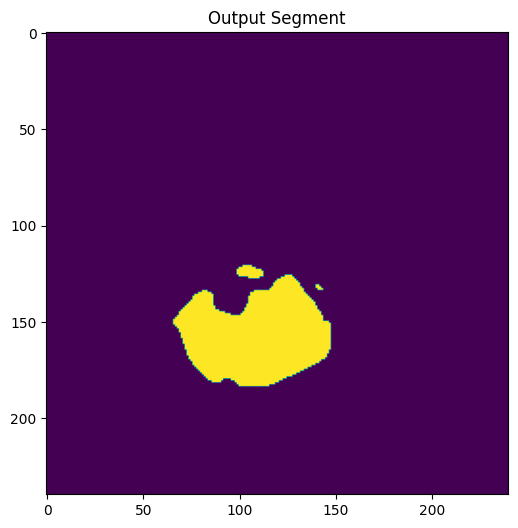

In [56]:
with torch.no_grad():
    
    val_input = val_ds[6]["image"].unsqueeze(0).to(device)
    roi_size = (192,192,64)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[6]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()
    
    plt.figure("label", (6, 6))
    plt.imshow(val_ds[6]["label"][1, :, :, 70].detach().cpu())
    plt.title('Ground Truth Segment')
    plt.show()
    
    plt.figure("output", (6, 6))
    plt.imshow(val_output[1, :, :, 70].detach().cpu())
    plt.title('Output Segment')
    plt.show()

In [54]:
def dwt_threshold(original_signal, wavelet='db1', level=1):
    coeffs = pywt.wavedec(original_signal, wavelet, level=level)
    return coeffs

def apply_threshold(coeffs, threshold_value, mode='hard'):
    thresholded_coeffs = [pywt.threshold(coeff, threshold_value, mode=mode) for coeff in coeffs]
    return thresholded_coeffs

def idwt_reconstruct(coeffs, wavelet='db1'):
    denoised_signal = pywt.waverec(coeffs, wavelet)
    return denoised_signal

def apply_wavelet_denoising(original_signal, wavelet ='db1', level = 3, threshold_value = 0.5, threshold_mode = 'hard') : 
    coeffs = dwt_threshold(original_signal, wavelet, level)
    thresholded_coeffs = apply_threshold(coeffs, threshold_value, mode=threshold_mode)
    denoised_signal = idwt_reconstruct(thresholded_coeffs, wavelet)
    return denoised_signal




### Inferencing with Denoising

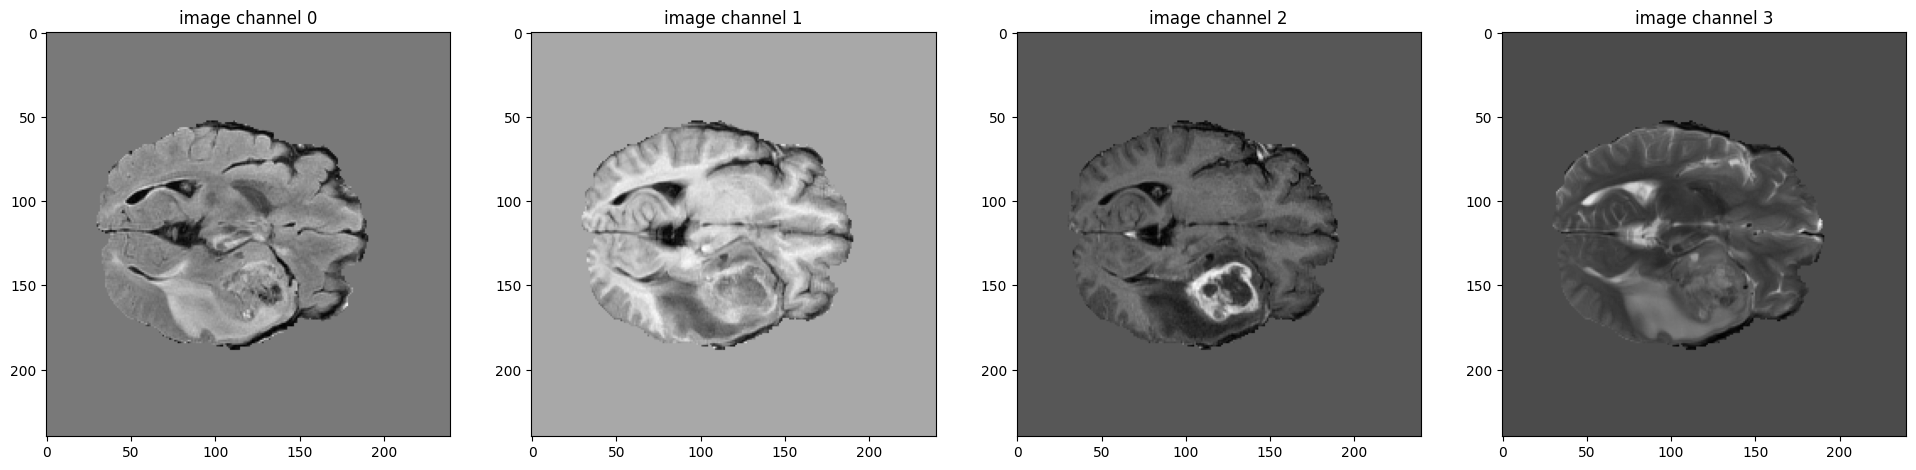

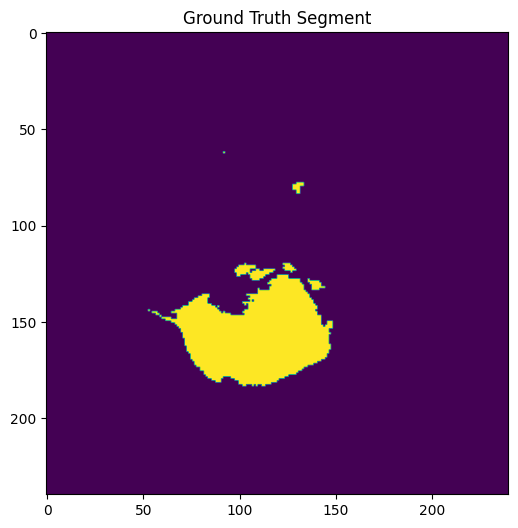

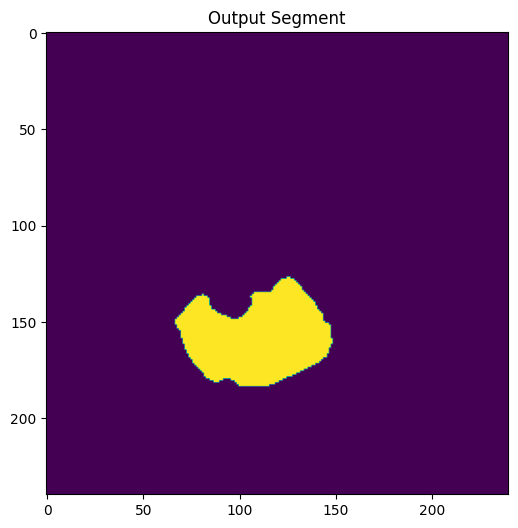

In [57]:
with torch.no_grad():
    
    val_input = val_ds[6]["image"].unsqueeze(0).to(device)
    val_array = val_input.squeeze(0).cpu().numpy()
    denoised_img = []
    for each in range(155) : 
        denoised_img.append(apply_wavelet_denoising(val_array[:,:,:,each], 'bior3.1', level = 1, threshold_value = 0.1, threshold_mode = 'soft'))
    denoised_img = torch.from_numpy(np.stack(denoised_img, axis = -1)).unsqueeze(0)
    val_input = denoised_img
    roi_size = (192, 192, 64)
    sw_batch_size = 4
    val_output_here = inference(val_input)
    val_output_denoised = post_trans(val_output_here[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[6]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()
    
    plt.figure("label", (6, 6))
    plt.imshow(val_ds[6]["label"][1, :, :, 70].detach().cpu())
    plt.title('Ground Truth Segment')
    plt.show()
    
    plt.figure("output", (6, 6))
    plt.imshow(val_output_denoised[1, :, :, 70].detach().cpu())
    plt.title('Output Segment')
    plt.show()

In [69]:
def normalize(x):
    norm = (x - x.min())/(x.max() - x.min())
    return norm

def plot_segment_anomaly_map(original_img, new_img) :
    anomaly =  +normalize(new_img) -normalize(original_img)*0.5
    anomaly = (anomaly - anomaly.min())/(anomaly.max() - anomaly.min())
    plt.colorbar(plt.imshow(anomaly, cmap='viridis', vmin=0, vmax=1))
    plt.cm.hot(anomaly)
    plt.show()

### Anomaly Maps without and with Denoising 

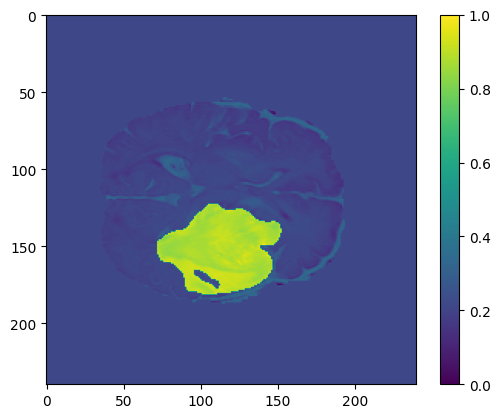

In [67]:
## Without Denoising

plot_segment_anomaly_map(val_input[0,0,:,:,80].numpy(), val_output[1, : ,:,80].numpy())

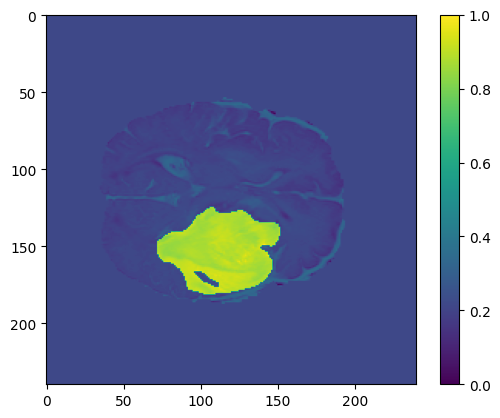

In [68]:
## With Denoising

plot_segment_anomaly_map(val_input[0,0,:,:,80].numpy(), val_output_denoised[1, : ,:,80].numpy())